# Preprocessing Demo

This is an interactive demo displaying how CLARIFY preprocesses the data with plotly visualizations. All of these functions can be run in one step via the command line (either the preprocess function in main.py or running "python main.py" itself).

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
import sys
import os
sys.path.append(os.path.abspath('./src/submodules/CeSpGRN/src/'))
sys.path.append(os.path.abspath('./src/submodules/'))
%load_ext autoreload
%autoreload 2
import src.preprocessing as pre
import src.visualize as vis
pio.renderers.default = "png" # change this if you want interactive plots


/nethome/mbafna6/miniconda3/envs/CeSpGRN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read in Example Data (SeqFISH+)

In [2]:
seqfish_counts_df = pd.read_csv("./data/seqFISH/counts.csv")
seqfish_celltype_df = pd.read_csv("./data/seqFISH/cell_type_1.csv")
seqfish_coords_df = pd.read_csv("./data/seqFISH/coord.csv")
seqfish_coords_df["Cell_ID"] = seqfish_celltype_df["Cell_ID"]
seqfish_df = seqfish_counts_df.copy()

numcells, numgenes = seqfish_counts_df.shape
numgenes = 45

seqfish_df.insert(0,'Cell_ID', seqfish_celltype_df["Cell_ID"])
seqfish_df.insert(1,'X', seqfish_coords_df["X"])
seqfish_df.insert(2,'Y', seqfish_coords_df["Y"])
seqfish_df.insert(3,'Cell_Type', seqfish_celltype_df["Cell_class_name"])
seqfish_df.to_csv("data/seqFISH/seqfish_dataframe.csv", index=False)
seqfish_df

,Cell_ID,X,Y,Cell_Type,4931431F19Rik,4932429P05Rik,Abca15,Abca9,Adcy4,Aldh3b2,...,calb1,gda,slc5a7,sema3e,mfge8,lyve1,loxl1,slco1c1,amigo2,kcnip
0,1,265.76,-231.14,neuron,1.83,1.52,2.41,-0.02,-0.28,1.95,...,0.12,-1.32,-2.06,-1.32,0.19,-2.20,-1.54,-1.40,2.51,0.60
1,2,290.48,-261.52,neuron,0.38,-0.04,0.59,0.03,0.93,0.49,...,-1.60,-0.64,-2.47,-1.34,0.00,0.22,-1.46,0.22,1.88,2.05
2,3,257.12,-133.35,neuron,0.82,0.12,0.67,-0.29,-0.42,-0.04,...,-0.66,-0.78,-1.07,-2.09,0.09,0.32,-2.29,0.15,3.20,2.30
3,4,753.46,-261.14,neuron,0.04,-1.27,-0.30,-0.52,-2.08,0.92,...,-0.85,-1.16,-1.29,-0.57,0.99,-0.19,-1.49,0.65,3.04,2.00
4,5,700.01,-169.05,neuron,0.52,0.44,-1.05,0.48,-0.49,2.29,...,-0.65,-0.97,-1.29,-1.77,1.09,-1.17,-2.11,0.36,2.47,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,1593,1129.06,-1669.57,neuron,-0.17,-0.50,1.03,0.90,0.23,0.48,...,-0.79,-0.31,-3.45,-2.60,-1.13,-1.97,-0.82,-1.53,2.21,0.54
1593,1594,1044.02,-1872.66,neuron,0.20,0.95,0.57,0.77,-2.34,-0.29,...,-0.57,-0.33,-1.13,-0.68,-0.06,-1.55,-0.43,-0.60,2.66,0.23
1594,1595,1388.76,-1880.47,neuron,-1.06,-0.18,-0.33,-0.05,-0.26,-0.22,...,1.04,0.54,1.38,0.90,-0.41,-1.69,0.36,-0.49,0.80,0.39
1595,1596,5172.85,-1340.96,neuron,-1.99,-0.25,1.34,0.00,-0.01,0.95,...,-1.28,-1.25,1.58,-2.68,-0.77,0.27,-0.60,-0.14,-2.66,0.37


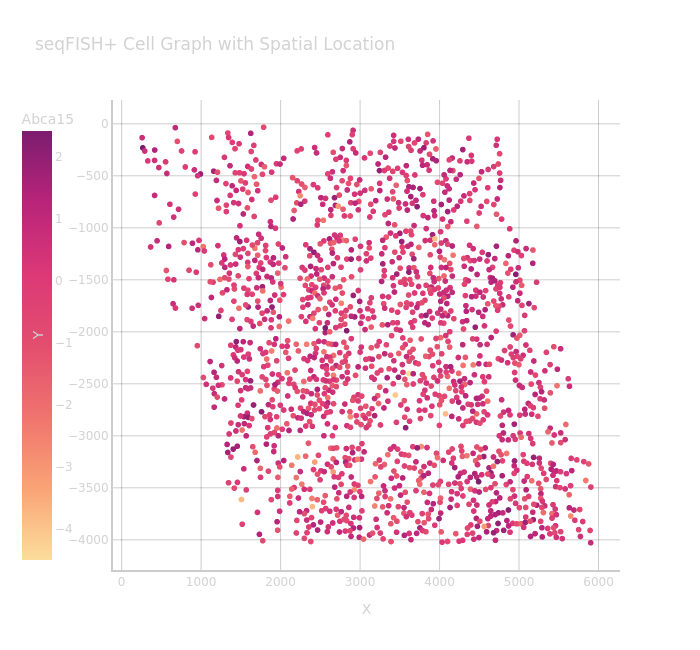

In [7]:
gene = "Abca15"
pio.renderers.default = "notebook_connected"
fig = vis.visualize_celllevel_graph(seqfish_df, gene, title =  f"seqFISH+ Cell Graph with Spatial Location", publication=False)
fig.show("png")
# fig.show() # uncomment this if you want interactive plots

# Preprocessing
1. Obtain starting Cell-Specific GRNs (from CeSpGRN)
2. Construct Cell-Level Graph from ST Data
3. Construct Gene-Level Graph from ST Data + GRNs

### 1. Inferring Cell-Specific GRNs

In [8]:
grns = np.load("./out/seqfish/1_preprocessing_output/initial_grns.npy") # shape (ncells, ngenes, ngenes)

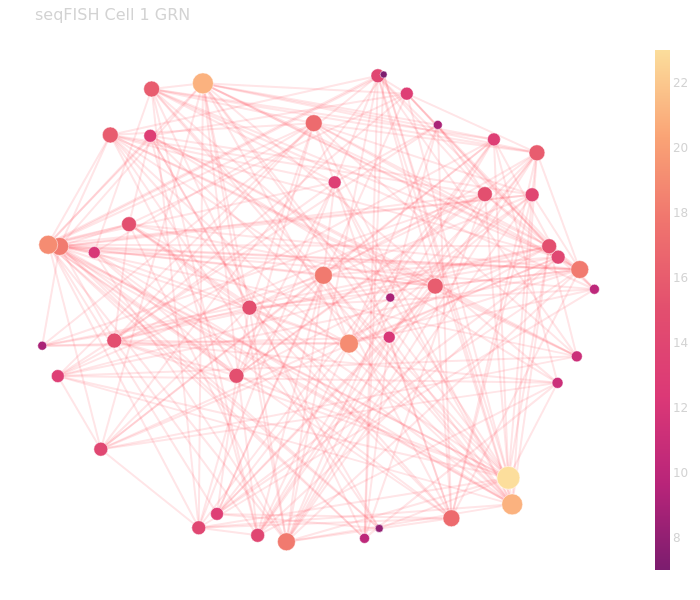

In [9]:
gene_attributes = {i:genename for i, genename in enumerate(seqfish_counts_df.columns[:45])}
pio.renderers.default = "notebook_connected"
fig = vis.visualize_grn_igviz(grns[0],gene_attributes, "seqFISH Cell 1 GRN")
fig.show("png")
# fig.show() # uncomment this if you want interactive plots

### 2. Constructing Cell-Level Graph

In [11]:
celllevel_adj, edges = pre.construct_celllevel_graph(seqfish_df, 5, get_edges=True)

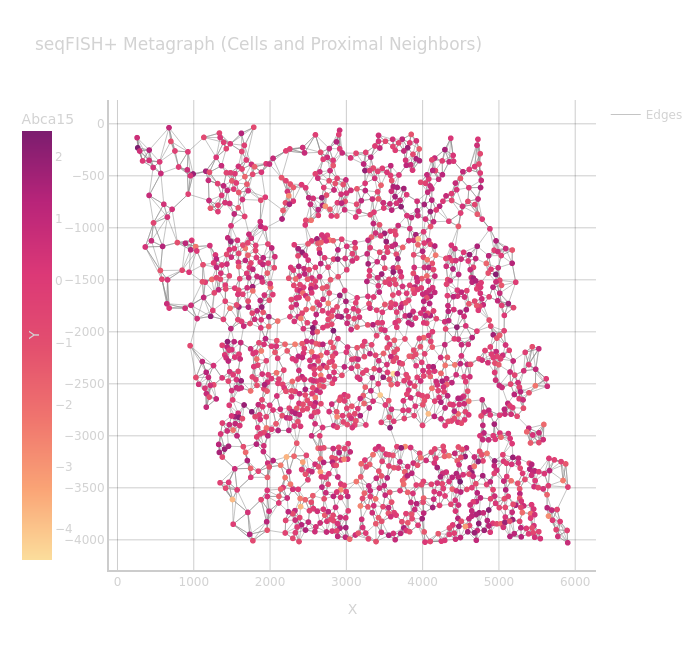

In [13]:
cell_level_graph_fig = vis.visualize_celllevel_graph(seqfish_df,gene,title = f"seqFISH+ Metagraph (Cells and Proximal Neighbors)",edge_trace=edges)
cell_level_graph_fig.show("png")
# cell_level_graph_fig.show() # uncomment this if you want interactive plots

### 3. Construct Gene Level Graph

In [10]:
gene_level_graph, num2gene, gen2num = pre.construct_genelevel_graph(grns, celllevel_adj, node_type="int")

len(gene_level_graph.nodes())

3b. Constructing Gene-Level Graph: 100%|██████████| 1597/1597 [00:09<00:00, 160.51it/s]


71865

### That is all for CLARIFY's preprocessing, now you are ready to train!